# Understanding LSTM Networks

## Recurrent Neural Networks

Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence.

Traditional neural networks can’t do this, and it seems like a major shortcoming. For example, imagine you want to classify what kind of event is happening at every point in a movie. It’s unclear how a traditional neural network could use its reasoning about previous events in the film to inform later ones.

Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.

<p align="center">
  <img src="img/lstm/RNN-rolled.png" width="150"/>
  <br>
  <em>Recurrent Neural Networks have loops</em>
</p>

In the above diagram, a chunk of neural network, A, looks at some input $x_t$ and outputs a value ht. A loop allows information to be passed from one step of the network to the next.

These loops make recurrent neural networks seem kind of mysterious. However, if you think a bit more, it turns out that they aren’t all that different than a normal neural network. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop:

<p align="center">
  <img src="img/lstm/RNN-unrolled.png" width="700"/>
  <br>
  <em>An unrolled recurrent neural network</em>
</p>

This chain-like nature reveals that recurrent neural networks are intimately related to sequences and lists. They’re the natural architecture of neural network to use for such data.

And they certainly are used! In the last few years, there have been incredible success applying RNNs to a variety of problems: speech recognition, language modeling, translation, image captioning… The list goes on. I’ll leave discussion of the amazing feats one can achieve with RNNs to Andrej Karpathy’s excellent blog post, The Unreasonable Effectiveness of Recurrent Neural Networks. But they really are pretty amazing.

Essential to these successes is the use of “LSTMs,” a very special kind of recurrent neural network which works, for many tasks, much much better than the standard version. Almost all exciting results based on recurrent neural networks are achieved with them. It’s these LSTMs that this essay will explore.

## The Problem of Long-Term Dependencies

One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? It depends.

Sometimes, we only need to look at recent information to perform the present task. For example, consider a language model trying to predict the next word based on the previous ones. If we are trying to predict the last word in “the clouds are in the *sky*,” we don’t need any further context – it’s pretty obvious the next word is going to be *sky*. In such cases, where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.

<p align="center">
  <img src="img/lstm/RNN-shorttermdepdencies.png" width="500"/>
  <br>
</p>

But there are also cases where we need more context. Consider trying to predict the last word in the text “I grew up in France… I speak fluent French.” Recent information suggests that the next word is probably the name of a language, but if we want to narrow down which language, we need the context of France, from further back. It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large.

Unfortunately, as that gap grows, RNNs become unable to learn to connect the information.

<p align="center">
  <img src="img/lstm/RNN-longtermdependencies.png" width="600"/>
  <br>
</p>

In theory, RNNs are absolutely capable of handling such “long-term dependencies.” A human could carefully pick parameters for them to solve toy problems of this form. Sadly, in practice, RNNs don’t seem to be able to learn them. The problem was explored in depth by Hochreiter (1991) [German] and Bengio, et al. (1994), who found some pretty fundamental reasons why it might be difficult.

Thankfully, LSTMs don’t have this problem!

## LSTM Networks

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

<p align="center">
  <img src="img/lstm/LSTM3-SimpleRNN.png" width="700"/>
  <br>
  <em>The repeating module in a standard RNN contains a single layer</em>
</p>

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<p align="center">
  <img src="img/lstm/LSTM3-chain.png" width="700"/>
  <br>
  <em>The repeating module in an LSTM contains four interacting layers</em>
</p>

Don’t worry about the details of what’s going on. We’ll walk through the LSTM diagram step by step later. For now, let’s just try to get comfortable with the notation we’ll be using.

<p align="center">
  <img src="img/lstm/LSTM2-notation.png" width="700"/>
  <br>
</p>

In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. The pink circles represent pointwise operations, like vector addition, while the yellow boxes are learned neural network layers. Lines merging denote concatenation, while a line forking denote its content being copied and the copies going to different locations.

## The Core Idea Behind LSTMs

The key to LSTMs is the cell state, the horizontal line running through the top of the diagram.

The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<p align="center">
  <img src="img/lstm/LSTM3-C-line.png" width="800"/>
  <br>
</p>

The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.

Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation.

<p align="center">
  <img src="img/lstm/LSTM3-gate.png" width="150"/>
  <br>
</p>

The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. A value of zero means “let nothing through,” while a value of one means “let everything through!”

An LSTM has three of these gates, to protect and control the cell state.

## Step-by-Step LSTM Walk Through

The first step in our LSTM is to decide what information we’re going to throw away from the cell state. This decision is made by a sigmoid layer called the “forget gate layer.” It looks at $h_{t−1}$ and xt, and outputs a number between 0 and 1 for each number in the cell state $C_{t−1}$. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

<p align="center">
  <img src="img/lstm/LSTM3-focus-f.png" width="800"/>
  <br>
</p>

The next step is to decide what new information we’re going to store in the cell state. This has two parts. First, a sigmoid layer called the “input gate layer” decides which values we’ll update. Next, a tanh layer creates a vector of new candidate values, $C̃_{t}$, that could be added to the state. In the next step, we’ll combine these two to create an update to the state.

<p align="center">
  <img src="img/lstm/LSTM3-focus-i.png" width="800"/>
  <br>
</p>

It’s now time to update the old cell state, $C_{t−1}$, into the new cell state $C_t$. The previous steps already decided what to do, we just need to actually do it.

We multiply the old state by ft, forgetting the things we decided to forget earlier. Then we add $i_t ∗ C̃_t$. This is the new candidate values, scaled by how much we decided to update each state value.

<p align="center">
  <img src="img/lstm/LSTM3-focus-C.png" width="800"/>
  <br>
</p>

Finally, we need to decide what we’re going to output. This output will be based on our cell state, but will be a filtered version. First, we run a sigmoid layer which decides what parts of the cell state we’re going to output. Then, we put the cell state through tanh (to push the values to be between −1 and 1) and multiply it by the output of the sigmoid gate, so that we only output the parts we decided to.

<p align="center">
  <img src="img/lstm/LSTM3-focus-o.png" width="800"/>
  <br>
</p>

## Variants on Long Short Term Memory

What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them.

One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state.

<p align="center">
  <img src="img/lstm/LSTM3-var-peepholes.png" width="800"/>
  <br>
</p>

The above diagram adds peepholes to all the gates, but many papers will give some peepholes and not others.

Another variation is to use coupled forget and input gates. Instead of separately deciding what to forget and what we should add new information to, we make those decisions together. We only forget when we’re going to input something in its place. We only input new values to the state when we forget something older.

<p align="center">
  <img src="img/lstm/LSTM3-var-tied.png" width="800"/>
  <br>
</p>

A slightly more dramatic variation on the LSTM is the Gated Recurrent Unit, or GRU, introduced by Cho, et al. (2014). It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models, and has been growing increasingly popular.

<p align="center">
  <img src="img/lstm/LSTM3-var-GRU.png" width="800"/>
  <br>
</p>

These are only a few of the most notable LSTM variants. There are lots of others, like Depth Gated RNNs by Yao, et al. (2015). There’s also some completely different approach to tackling long-term dependencies, like Clockwork RNNs by Koutnik, et al. (2014).

Which of these variants is best? Do the differences matter? Greff, et al. (2015) do a nice comparison of popular variants, finding that they’re all about the same. Jozefowicz, et al. (2015) tested more than ten thousand RNN architectures, finding some that worked better than LSTMs on certain tasks.



## Conclusion

Earlier, I mentioned the remarkable results people are achieving with RNNs. Essentially all of these are achieved using LSTMs. They really work a lot better for most tasks!

Written down as a set of equations, LSTMs look pretty intimidating. Hopefully, walking through them step by step in this essay has made them a bit more approachable.

LSTMs were a big step in what we can accomplish with RNNs. It’s natural to wonder: is there another big step? A common opinion among researchers is: “Yes! There is a next step and it’s attention!” The idea is to let every step of an RNN pick information to look at from some larger collection of information. For example, if you are using an RNN to create a caption describing an image, it might pick a part of the image to look at for every word it outputs. In fact, Xu, et al. (2015) do exactly this – it might be a fun starting point if you want to explore attention! There’s been a number of really exciting results using attention, and it seems like a lot more are around the corner…

Attention isn’t the only exciting thread in RNN research. For example, Grid LSTMs by Kalchbrenner, et al. (2015) seem extremely promising. Work using RNNs in generative models – such as Gregor, et al. (2015), Chung, et al. (2015), or Bayer & Osendorfer (2015) – also seems very interesting. The last few years have been an exciting time for recurrent neural networks, and the coming ones promise to only be more so!

# LSTM code implementation

Let's get started with Data Preparation for the LSTM  implementation!

In [1]:
# import required libraries
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

### Data preparation

**Example**

To understand how should we prepare the data for LSTM, we’ll use a simple dataset as a Timeseries Forecasting example. Below is the full sequence of values and their restructuring as a training and testing dataset.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/SequenceDataPerparation.webp" width="400">

Now, let’s separate the datasets into batches!

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/Seq_DataPerparation_2.webp" width="100">

In [ ]:
# generate time series data
np.random.seed(42)
t = np.arange(0, 200) 

# Components
trend = 0.05 * t  # Linear trend
seasonality = 2 * np.sin(0.2 * t)  # seasonality
noise = np.random.normal(scale=0.5, size=len(t))  # Random noise

# Final signal
df = trend + seasonality + noise
df = pd.DataFrame(df, columns=['value'])

df.shape

(200, 1)

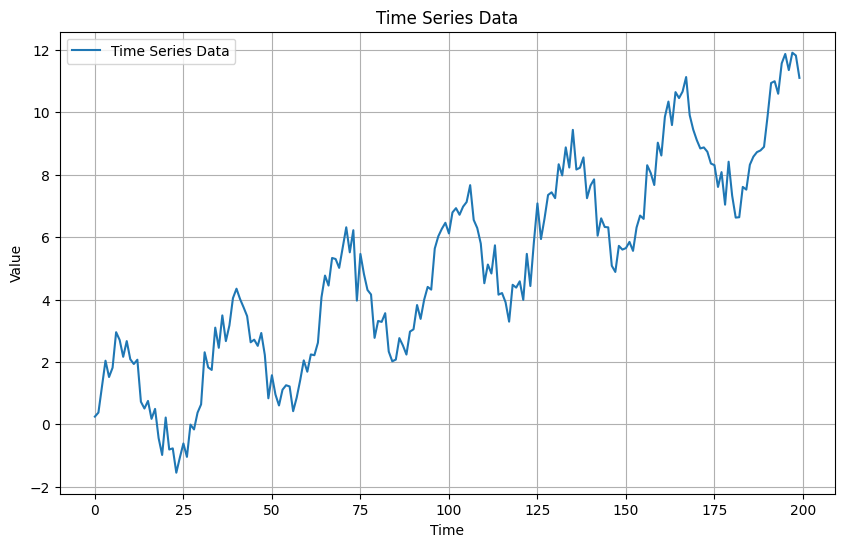

In [5]:
# plot time series data
plt.figure(figsize=(10, 6))
plt.plot(df['value'], label='Time Series Data')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)
data_scaled.shape

(200, 1)

In [8]:
# Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size] # 80% for training
test_data = data_scaled[train_size:] # 20% for testing

train_data.shape, test_data.shape

((160, 1), (40, 1))

In [9]:
# Further split the 'training data' into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size] # 80% of training data for training
valid_data = train_data[train_valid_size:] # 20% of training data for validation

train_data_final.shape, valid_data.shape

((128, 1), (32, 1))

In [10]:
# Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index): 
    """
    Create sequences for multivariate time series data
    Args:
        data (numpy array): The input data
        n_timesteps (int): Number of timesteps to look back
        target_column_index (int): Index of the target column
    Returns:
        X (numpy array): Input sequences
        y (numpy array): Target values
    """
    
    X = []
    y = []
    for i in range(len(data) - n_timesteps): 
        seq_x = data[i:i + n_timesteps] # Get the sequence of n_timesteps
        seq_y = data[i + n_timesteps, target_column_index] # Get the target value at the next timestep
        X.append(seq_x) 
        y.append(seq_y)
    return np.array(X), np.array(y) 

Implementing code for LSTM and RNN requires sequential data preparation. The data preparation process for these models is visualized here!


<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/sequence.gif" width="800">


In [11]:
n_timesteps = 10
n_features = data_scaled.shape[1] 
target_column_index = 0 # Assuming the first column is the target

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((118, 10, 1), (118,), (22, 10, 1), (22,), (30, 10, 1), (30,))

In [12]:
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32) # Convert to float32 tensor
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([118, 10, 1]),
 torch.Size([118]),
 torch.Size([22, 10, 1]),
 torch.Size([22]),
 torch.Size([30, 10, 1]),
 torch.Size([30]))

In [13]:
# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train) # Create TensorDataset for training
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False) # Create DataLoader for training
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train_loader

We then have to prepare the dataset. We need the data as Pytorch tensors so that we can use that in our model which we will make. We use the dataloader so that we can extract the data in batches. This is especially helpful for large datasets.

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/TensorDataset.webp" width="900">



### Training LSTM

In order to create a LSTM, we follow the same steps as for implementing an ANN!



- Creating a Neural Network
- Network Evaluation
- Gradient Calculation
- Back Propagation
- Training

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/LSTM_dynamic.gif" width="800">



In [14]:
# note:
# - input size : number of features in the input data
# - hidden size : number of features in the hidden state of the LSTM
# - num_layers : number of recurrent layers in the LSTM
# - dropout : regularization technique to prevent overfitting
# - batch size : number of samples processed before the model is updated

# Build the LSTM Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.2): 
        """
        Initialize the LSTM model
        Args:
            input_size (int): Number of features in the input
            hidden_size (int): Number of features in the hidden state
            num_layers (int): Number of recurrent layers
            output_size (int): Number of output features
            dropout (float): Dropout rate
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout) 
        
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer to map the LSTM output to the desired output size

    def forward(self, x):
        """
        Forward pass through the LSTM model
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, input_size)
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_size)
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Initial cell state

        out, (hn, cn) = self.lstm(x, (h0, c0)) # Forward pass through LSTM
        out = out[:, -1, :]  # Last time step
        out = self.fc(out) # Fully connected layer to get the final output
        return out

In [15]:
# Instantiate the LSTM model
model = LSTMModel(input_size=n_features, hidden_size=50, num_layers=1, output_size=1, dropout=0.2)

# Define loss function and optimizer
# Loss Function
criterion = nn.MSELoss()

# Optimization Approach
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer with learning rate 0.001

# Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Set device to GPU if available, else CPU
model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [16]:
# Note:
# - epochs : number of times the entire training dataset is passed through the model
# - batch_size : number of samples processed before the model is updated

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train() 
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device) 
        targets = targets.to(device)

        optimizer.zero_grad() # Zero the gradients 

        # Forward Pass
        outputs = model(inputs) 

        # FeedForward Evaluation (loss)
        loss = criterion(outputs.squeeze(), targets)

        # Backward Pass / Gradient Calculation
        loss.backward()
        # Note: The optimizer will update the weights based on the gradients calculated in the backward pass

        # Back Propagation / Update Weights
        optimizer.step() 

        # Accumulate the training loss
        train_loss += loss.item() * inputs.size(0) 

    train_loss /= len(train_loader.dataset) # Average the training loss over the entire dataset
    train_losses.append(train_loss) # for plot

    # Validation 
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs) # Forward pass through the model
            loss = criterion(outputs.squeeze(), targets) # Calculate the loss for validation
            valid_loss += loss.item() * inputs.size(0) 
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50, Train Loss: 0.021903, Valid Loss: 0.026336
Epoch 4/50, Train Loss: 0.017875, Valid Loss: 0.012982
Epoch 6/50, Train Loss: 0.012460, Valid Loss: 0.012656
Epoch 8/50, Train Loss: 0.006707, Valid Loss: 0.007365
Epoch 10/50, Train Loss: 0.003390, Valid Loss: 0.002220
Epoch 12/50, Train Loss: 0.003094, Valid Loss: 0.002793
Epoch 14/50, Train Loss: 0.003630, Valid Loss: 0.004408
Epoch 16/50, Train Loss: 0.003105, Valid Loss: 0.003457
Epoch 18/50, Train Loss: 0.002888, Valid Loss: 0.002900
Epoch 20/50, Train Loss: 0.002819, Valid Loss: 0.002724
Epoch 22/50, Train Loss: 0.002807, Valid Loss: 0.002756
Epoch 24/50, Train Loss: 0.002808, Valid Loss: 0.002839
Epoch 26/50, Train Loss: 0.002794, Valid Loss: 0.002866
Epoch 28/50, Train Loss: 0.002773, Valid Loss: 0.002858
Epoch 30/50, Train Loss: 0.002760, Valid Loss: 0.002877
Epoch 32/50, Train Loss: 0.002753, Valid Loss: 0.002919
Epoch 34/50, Train Loss: 0.002738, Valid Loss: 0.002911
Epoch 36/50, Train Loss: 0.002728, Valid Loss: 0.002

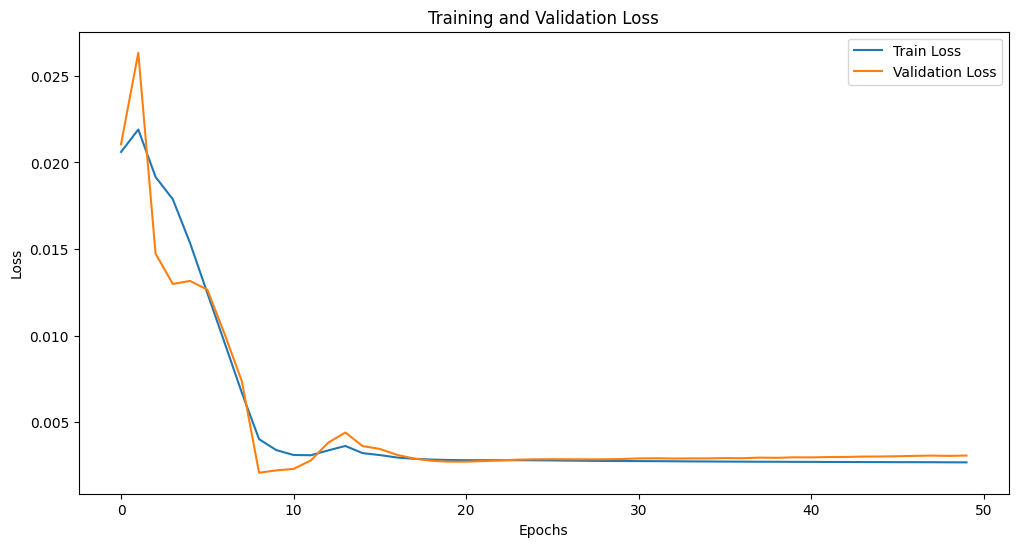

In [17]:
# plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate the Model
model.eval()
with torch.no_grad(): # this way prevents PyTorch from storing unnecessary information for backpropagation, making inference faster and more memory-efficient.
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()


test_preds.shape, test_actuals.shape

((30, 1), (30,))

In [19]:
# Denormalize and Visualize Predictions
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    data = scaler.inverse_transform(data)
    return data[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

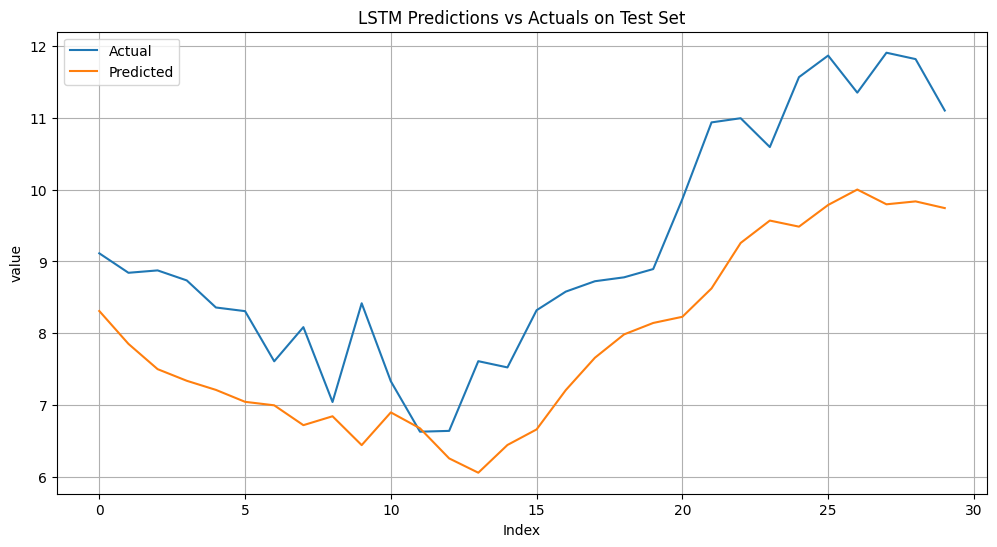

In [20]:
# plot
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('value')
plt.grid(True)
plt.legend()
plt.show()

## LSTM from scratch

In [21]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import lightning as L
from torch.utils.data import DataLoader, TensorDataset

In [22]:
class LSTMbyHand(L.LightningModule):

    # Initialize the LSTM model parameters
    def __init__(self):
        super().__init__()
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)

        self.wf1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wf2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bf1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wi1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wi2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bi1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wc1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wc2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bc1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    # Define the LSTM unit
    def lstm_unit(self, input_value, long_memory, short_memory):
        long_remember_percent = torch.sigmoid((short_memory * self.wf1) + 
                                              (input_value * self.wf2) +
                                              self.bf1)
        potential_remember_percent = torch.sigmoid((short_memory * self.wi1) + 
                                                   (input_value * self.wi2) +
                                                   self.bpr1)
        potential_memory = torch.tanh((short_memory * self.wc1) +
                                      (input_value * self.wc2) +
                                      self.bc1)
        updated_long_memory = ((long_memory * long_remember_percent) +
                               (potential_remember_percent * potential_memory))
        output_percent = torch.sigmoid((short_memory * self.wo1) +
                                       (input_value * self.wo2) +
                                       self.bo1)
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        return ([updated_long_memory, updated_short_memory])

    # Define the forward pass of the LSTM
    def forward(self, input):
        long_memory = torch.zeros(input.shape[0], input.shape[2])
        short_memory = torch.zeros(input.shape[0], input.shape[2])
        for i in range(input.shape[1]):
            long_memory, short_memory = self.lstm_unit(input[:, i, :], long_memory, short_memory)
        return short_memory

    # Define the optimizer
    def configure_optimizers(self):
        return Adam(params=self.parameters())

    # Define the training step
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])
        loss = F.mse_loss(output_i, label_i[0])
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

In [23]:
model = LSTMbyHand()